<a href="https://colab.research.google.com/github/KesteHarshada87/MachineLearning/blob/main/LogisticRegressionConfusionMetrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Epoch    0 | Cost: 0.693147
Epoch  200 | Cost: 2.185441
Epoch  400 | Cost: 0.829876
Epoch  600 | Cost: 0.410676
Epoch  800 | Cost: 1.552285

Test Cost: 0.483025

📊 Evaluation Metrics (Test):
Accuracy : 0.8715
Precision: 0.8715
Recall   : 1.0000
F1-Score : 0.9313


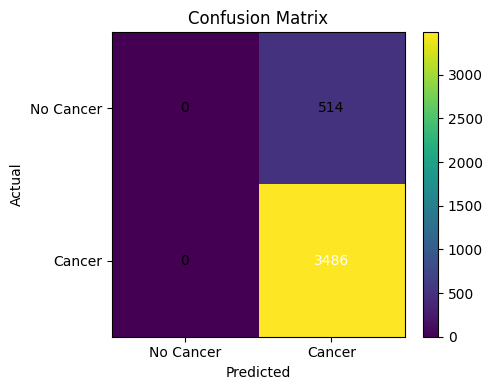


AUC: 0.5026967235255642
FPR (first 5): [0.     0.     0.0019 0.0019 0.0039]
TPR (first 5): [0.     0.0003 0.0003 0.0014 0.0014]


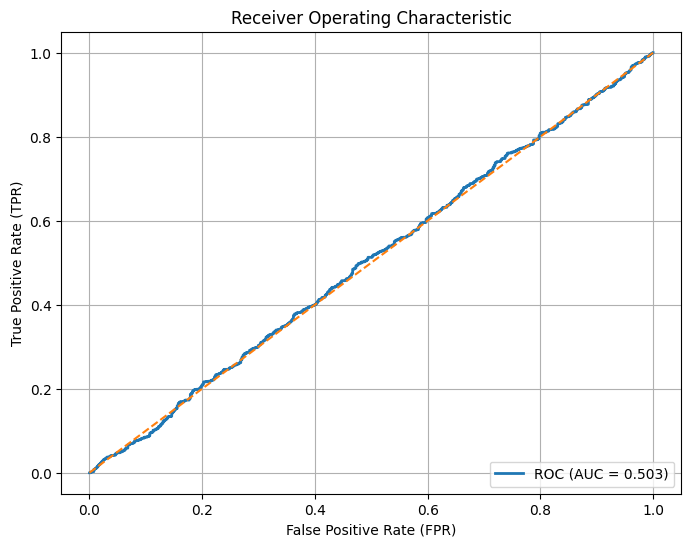

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix
)

# ---------- Load data ----------
csv_path = '/content/drive/MyDrive/MachineLearning/lcs_synthetic_20000.csv'
df = pd.read_csv(csv_path)

# If your column names have spaces/trailing spaces, keep them exactly:
feature_cols = [
    'AGE','SMOKING','YELLOW_FINGERS','ANXIETY','PEER_PRESSURE','CHRONIC DISEASE','FATIGUE ','ALLERGY ','WHEEZING','ALCOHOL CONSUMING','COUGHING','SHORTNESS OF BREATH','SWALLOWING DIFFICULTY','CHEST PAIN'
]

X = df[feature_cols].values.astype(float)

# Make sure target is 0/1 numeric (handles strings like 'YES'/'NO' too)
Y_raw = df['LUNG_CANCER'].values
if Y_raw.dtype.kind in 'iu':
    Y = Y_raw.astype(int)
else:
    Y = np.array([1 if str(v).strip().upper() in ('1','YES','TRUE') else 0 for v in Y_raw], dtype=int)

# ---------- Train/Test split ----------
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

# ---------- Logistic regression (manual GD) ----------
def compute_z(w, b, X):
    # X: (m,n), w: (n,), returns (m,)
    return X @ w + b

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def compute_cost(Y_true, Y_prob, eps=1e-15):
    m = len(Y_true)
    # clamp to avoid log(0)
    Y_prob = np.clip(Y_prob, eps, 1 - eps)
    return - (1/m) * np.sum(Y_true*np.log(Y_prob) + (1 - Y_true)*np.log(1 - Y_prob))

def compute_gradient(X, Y_true, Y_prob):
    m = len(Y_true)
    error = (Y_prob - Y_true)  # (m,)
    dw = (1/m) * (X.T @ error) # (n,)
    db = (1/m) * np.sum(error) # scalar
    return dw, db

# Initialize
w = np.zeros(X_train.shape[1])
b = 0.0
learning_rate = 0.01
epochs = 1000

# Train
for epoch in range(epochs):
    z = compute_z(w, b, X_train)
    Y_prob = sigmoid(z)
    cost = compute_cost(Y_train, Y_prob)
    dw, db = compute_gradient(X_train, Y_train, Y_prob)

    w -= learning_rate * dw
    b -= learning_rate * db

    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Cost: {cost:.6f}")

# ---------- Evaluate on test ----------
z_test = compute_z(w, b, X_test)
Y_pred_test = sigmoid(z_test)                  # probabilities
Y_pred_test_class = (Y_pred_test >= 0.5).astype(int)  # hard labels

test_cost = compute_cost(Y_test, Y_pred_test)
print(f"\nTest Cost: {test_cost:.6f}")

# ---- Classification metrics ----
accuracy  = accuracy_score(Y_test, Y_pred_test_class)
precision = precision_score(Y_test, Y_pred_test_class, pos_label=1, zero_division=0)
recall    = recall_score(Y_test, Y_pred_test_class, pos_label=1, zero_division=0)
f1        = f1_score(Y_test, Y_pred_test_class, pos_label=1, zero_division=0)

print("\n📊 Evaluation Metrics (Test):")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")

# ---- Confusion Matrix (Matplotlib only, no seaborn needed) ----
cm = confusion_matrix(Y_test, Y_pred_test_class)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest', aspect='auto')
plt.title('Confusion Matrix')
plt.colorbar()
classes = ['No Cancer','Cancer']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
# overlay counts
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i,j]:d}",
                 ha="center", va="center",
                 color="white" if cm[i,j] > thresh else "black")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# ---- ROC curve + AUC ----
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_test, pos_label=1)
roc_auc = auc(fpr, tpr)

print("\nAUC:", roc_auc)
print("FPR (first 5):", np.round(fpr[:5], 4))
print("TPR (first 5):", np.round(tpr[:5], 4))

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
